In [1]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 4.2 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=a04dca6fcd95a6a0497dbe0bb45dae9e6bfa2d2a48dfafcd970760c842747c35
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

In [29]:
BTC = yf.download('BTC-USD',start='2016-01-01')['Close']

[*********************100%***********************]  1 of 1 completed


In [26]:
aapl = yf.download('AAPL',start='2016-01-01')["Close"]

[*********************100%***********************]  1 of 1 completed


In [30]:
BTC = pd.DataFrame.from_dict(BTC)
#Keep only the close column
BTC = BTC[['Close']]
#Rename the column name to BTC
BTC.columns = ['BTC']
BTC

,BTC
Date,
2016-01-01,434.334015
2016-01-02,433.437988
2016-01-03,430.010986
2016-01-04,433.091003
2016-01-05,431.959991
...,...
2021-10-15,61593.949219
2021-10-16,60892.179688
2021-10-17,61553.617188


In [31]:
aapl = pd.DataFrame.from_dict(aapl)
#Keep only the close column
aapl = aapl[['Close']]
#Rename the column name to aapl
aapl.columns = ['aapl']
aapl

,aapl
Date,
2016-01-04,26.337500
2016-01-05,25.677500
2016-01-06,25.174999
2016-01-07,24.112499
2016-01-08,24.240000
...,...
2021-10-12,141.509995
2021-10-13,140.910004
2021-10-14,143.759995


In [32]:
AAPLBTC = BTC.merge(aapl, how='inner',right_index = True, left_index=True)

In [33]:
AAPLBTC

,BTC,aapl
Date,,
2016-01-04,433.091003,26.337500
2016-01-05,431.959991,25.677500
2016-01-06,429.105011,25.174999
2016-01-07,458.048004,24.112499
2016-01-08,453.230011,24.240000
...,...,...
2021-10-12,56041.058594,141.509995
2021-10-13,57401.097656,140.910004
2021-10-14,57321.523438,143.759995


In [35]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [36]:
window_size = 10

In [37]:
feature_column = 1
target_column = 1
X, y = window_data(SP500BTC, window_size, feature_column, target_column)

In [38]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [39]:

from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [40]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [42]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 9
dropout_fraction = 0.2


# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [43]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [44]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 9)             396       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 9)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 9)             684       
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 9)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 9)                 684       
_________________________________________________________________
dropout_5 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [45]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=10, verbose=1)

Epoch 1/10
101/101 [==============================] - 5s 10ms/step - loss: 0.0044
Epoch 2/10
101/101 [==============================] - 1s 10ms/step - loss: 0.0098
Epoch 3/10
101/101 [==============================] - 1s 10ms/step - loss: 0.0070
Epoch 4/10
101/101 [==============================] - 1s 10ms/step - loss: 0.0043
Epoch 5/10
101/101 [==============================] - 1s 9ms/step - loss: 0.0030
Epoch 6/10
101/101 [==============================] - 1s 9ms/step - loss: 0.0026
Epoch 7/10
101/101 [==============================] - 1s 9ms/step - loss: 0.0020
Epoch 8/10
101/101 [==============================] - 1s 10ms/step - loss: 0.0019
Epoch 9/10
101/101 [==============================] - 1s 9ms/step - loss: 0.0019
Epoch 10/10
101/101 [==============================] - 1s 9ms/step - loss: 0.0018


In [46]:
# Evaluate the model
model.evaluate(X_test, y_test)

14/14 [==============================] - 1s 3ms/step - loss: 0.0154


0.015354334376752377

In [47]:
# Make some predictions
predicted = model.predict(X_test)

In [48]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [49]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = SP500BTC.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
Date,,
2020-01-24,3325.540039,3264.072510
2020-01-27,3295.469971,3270.851318
2020-01-28,3243.629883,3275.475830
2020-01-29,3276.239990,3279.804443
2020-01-30,3273.399902,3280.823730


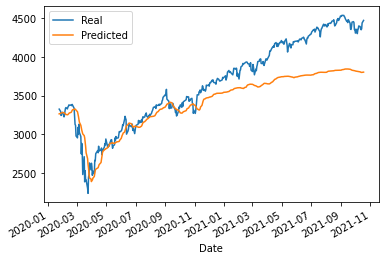

In [50]:
# Plot the real vs predicted values as a line chart
stocks.plot()